# Evaluate Separation Quality

## Evaluate by Listening

In [107]:
import nussl
import matplotlib.pyplot as plt
import time
import torch
import json

import warnings
warnings.filterwarnings("ignore")


### Listen to room (the state) at beginning of episode

In [108]:
# new0-1 is new state in episode 0, step 1
room_sound_path = '../data/new_states/new2-1.wav'
room_sound = nussl.AudioSignal(room_sound_path)
room_sound.embed_audio(display=False)

Then select the right model (usually the latest episode) from the correct experiment folder.

In [121]:
# final run: ep 10 is not bad
model_path = '../models/new-exp-150eps/sp_ep150.pt'

Then put the mix through the model to hear the result.

STFTParams(window_length=256, hop_length=64, window_type='sqrt_hann')
SeparationModel(
  (layers): ModuleDict(
    (audio): STFT()
    (concatenate): Concatenate()
    (estimates): Mask()
    (expand): Expand()
    (log_spectrogram): AmplitudeToDB()
    (mask): Embedding(
      (linear): Linear(in_features=100, out_features=258, bias=True)
    )
    (normalization): BatchNorm(
      (batch_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (recurrent_stack): RecurrentStack(
      (rnn): LSTM(129, 50, batch_first=True, dropout=0.3, bidirectional=True)
    )
    (split): Split()
  )
)
Number of parameters: 98460
[<nussl.core.audio_signal.AudioSignal object at 0x7f56ee3c9048>, <nussl.core.audio_signal.AudioSignal object at 0x7f56ee3c99b0>]


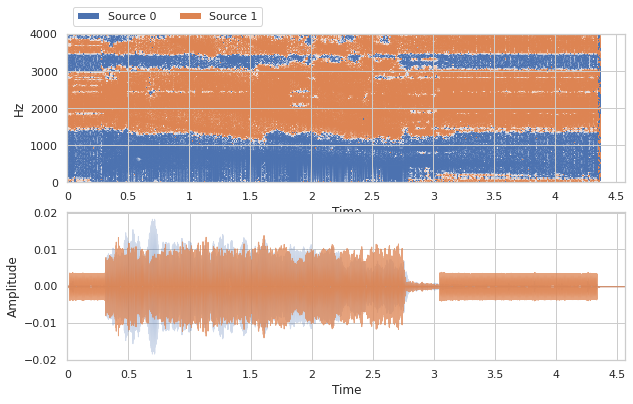


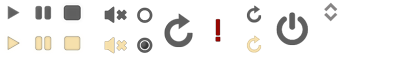
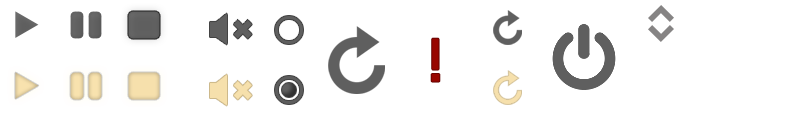
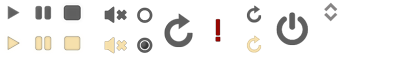

In [122]:
start_time = time.time()

def visualize_and_embed(sources):
    plt.figure(figsize=(10, 6))
    plt.subplot(211)
    nussl.utils.visualize_sources_as_masks(sources,
        y_axis='linear', db_cutoff=-80, alpha_amount=2.0)
    plt.subplot(212)
    nussl.utils.visualize_sources_as_waveform(
        sources, show_legend=False)
    plt.show()
    nussl.play_utils.multitrack(sources)

# audio_path = nussl.efz_utils.download_audio_file(
#     'wsj_speech_mixture_ViCfBJj.mp3')

# for testing on new data
audio_files = [
    '../sounds/samples/male/051a050c.wav',
    '../sounds/samples/female//050a050a.wav'
]

# can't do these files because they have different # of channels
# need to do to_mono?
# signals[0]._audio_data.shape == (1, x)
# signals[1]._audio_data.shape == (2, x)
# audio_files = [
#      '../sounds/phone/cellphone_ringing.wav',
#      '../sounds/siren/siren.wav'
#  ]
signals = []
gains = [1, 1]

for i, a in enumerate(audio_files):
    sig = nussl.AudioSignal(a)
    signals.append(sig * gains[i])
       
min_length = min([x.signal_duration for x in signals])
[x.truncate_seconds(min_length) for x in signals]
audio_signal = sum(signals)

separator = nussl.separation.deep.DeepAudioEstimation(
    room_sound, model_path=None)

model_dict = torch.load(model_path)
model = nussl.ml.SeparationModel(model_dict['config'])
model.load_state_dict(model_dict['state_dict'])
print(audio_signal.stft_params)
separator.model = model
print(separator.model)
separator.metadata = {
    'sample_rate': model_dict['metadata']['sample_rate'],
    'stft_params': audio_signal.stft_params,
    'num_channels': 1
}
separator.transform = nussl.datasets.transforms.Compose([
    nussl.datasets.transforms.GetAudio(),
    nussl.datasets.transforms.ToSeparationModel(),
])
separator.device = 'cpu'

otoworld_estimates = separator()
print(otoworld_estimates)
ibm = nussl.separation.benchmark.IdealBinaryMask(
    room_sound, otoworld_estimates, 
)
otoworld_estimates = ibm()

otoworld_estimates = {
    f'Source {i}': e for i, e in enumerate(otoworld_estimates)
}

visualize_and_embed(otoworld_estimates)

#### Predicted Sources are downloadable

In [123]:
otoworld_estimates['Source 0'].embed_audio(display=False)

In [124]:
otoworld_estimates['Source 1'].embed_audio(display=False)

### IMPORTANT NOTE FOR EVALUATION

Note which predicted source seems to corresponds to which actual source. 

i.e. does Source 0 above sound like its the car horn or the phone? What about Source 1? 

### Inspect the Mask

In [125]:
separator.model_output['mask'].mean(dim=[0, 1, 2, 3])

tensor([0.4157, 0.5843])

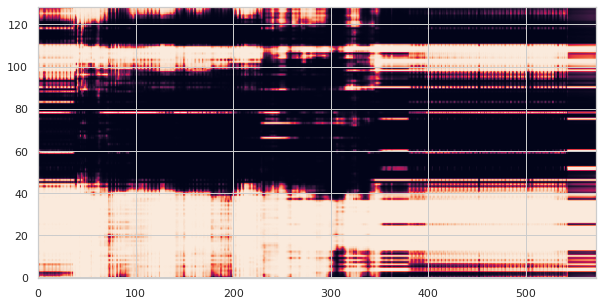

In [126]:
# spectrogram is multiplied by the mask to separate sources 
plt.imshow(separator.model_output['mask'][0, ..., 0, 0].cpu().data.numpy().T, 
           origin='lower', aspect='auto', vmin=0.0, vmax=1.0)

In [127]:
separator.model_output['mask'][0, 0, 0]

tensor([[0.1215, 0.8785]])

## Compare to Separation using Spatial Clustering

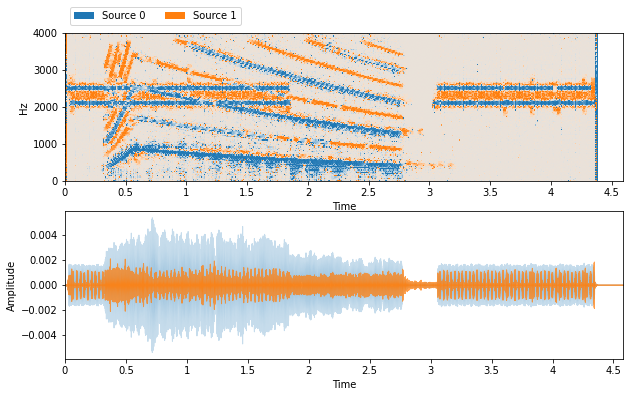


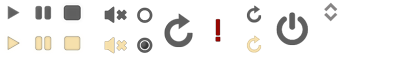
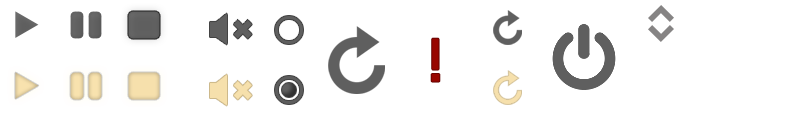
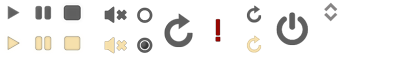

In [45]:
spcl = nussl.separation.spatial.SpatialClustering(
    room_sound, num_sources=2, mask_type='binary'
)
clustering_estimates = spcl()

clustering_estimates = {
    f'Source {i}': e for i, e in enumerate(clustering_estimates)
}

visualize_and_embed(clustering_estimates)

## Evaluate with Metrics
Specifically, using SDR (source-to-distortion) ratio

In [46]:
otoworld_estimates

{'Source 0': <nussl.core.audio_signal.AudioSignal at 0x7f56f8d08438>,
 'Source 1': <nussl.core.audio_signal.AudioSignal at 0x7f56f8d08278>}

#### Load ground truth sources - need to re-create env
Ground truth: agent and sources at their initial locations in the room, computer the RIR with only one source turned on and that will represent the ground truth for that source. Do the same for the other source.

In [53]:
# just copying experiment5.py code for now to replicate env
import sys
sys.path.append("../src/")
from datetime import datetime
import os

import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import logging
from torch.utils.tensorboard import SummaryWriter

import room_types
import agent
import audio_room
import utils
import constants
import nussl
from datasets import BufferData
import time
import audio_processing
from models import RnnAgent
import transforms

# For plotting using seaborn 
import plot_runs  

In [54]:
# Shoebox Room
nussl.utils.seed(7)
room = room_types.ShoeBox(x_length=8, y_length=8)

source_folders_dict = {'../sounds/phone/': 1,
                        '../sounds/siren/': 1}

# Set up the gym environment
env = gym.make(
    "audio-room-v0",
    room_config=room.generate(),
    source_folders_dict=source_folders_dict,
    corners=room.corners,
    max_order=10,
    step_size=1.0,
    acceptable_radius=1.0,
    absorption=1.0,
    reset_sources=False,
    same_config=True
)
env.seed(7)

# fixing lengths
tfm = transforms.Compose([
    transforms.GetAudio(mix_key=['prev_state', 'new_state']),
    transforms.ToSeparationModel(),
    transforms.GetExcerpt(excerpt_length=32000,
                          tf_keys=['mix_audio_prev_state'], time_dim=1),
    transforms.GetExcerpt(excerpt_length=32000,
                          tf_keys=['mix_audio_new_state'], time_dim=1)
])

# create dataset object (subclass of nussl.datasets.BaseDataset)
dataset = BufferData(
    folder=constants.DIR_DATASET_ITEMS,
    to_disk=True,
    transform=tfm
)

# create agent obj (same env config as the training to get ground truth)
agent.RandomAgent(env=env, dataset=dataset, episodes=1, max_steps=2)

Source locs [[5.65761384716134, 5.871071402613153], [0.8211730703874749, 3.0]]
Placing agent at [3.7420228779598457, 1.6387927223823606]


In [55]:
# source 0 and source 1
print(env.direct_sources)
print(env.source_locs)

['../sounds/phone/cellphone_ringing.wav', '../sounds/siren/siren.wav']
[[5.65761384716134, 5.871071402613153], [0.8211730703874749, 3.0]]


In [56]:
print(len(env.room.sources[0].signal))
print(len(env.room.sources[1].signal))

34523
34523


Get ground truth for source 0

In [57]:
ground_truth_sources = []

In [58]:
# remove src 1 to get ground truth for src 0
env._remove_source(index=1)
print(env.direct_sources)
print(env.source_locs)

['../sounds/phone/cellphone_ringing.wav']
[[5.65761384716134, 5.871071402613153]]


In [59]:
print(len(env.room.sources[0].signal))

34523


In [60]:
# get ground truth for src 0
env.room.compute_rir()
env.room.simulate()
ground_truth0_np = env.room.mic_array.signals
print(ground_truth0_np.shape)

# convert to nussl AudioSignal
ground_truth0 = nussl.AudioSignal(audio_data_array=ground_truth0_np, sample_rate=env.resample_rate)
ground_truth0.embed_audio(display=False)

(2, 36570)


In [61]:
print(len(ground_truth0))
ground_truth_sources.append(ground_truth0)

36570


Get ground truth for source 1

In [62]:
# add back src 1
env.reset(removing_source=0)

print(env.direct_sources)
print(env.source_locs)

Source locs [[5.65761384716134, 5.871071402613153], [0.8211730703874749, 3.0]]
Placing agent at [3.7420228779598457, 1.6387927223823606]
['../sounds/phone/cellphone_ringing.wav', '../sounds/siren/siren.wav']
[[5.65761384716134, 5.871071402613153], [0.8211730703874749, 3.0]]


In [63]:
print(len(env.room.sources[0].signal))
print(len(env.room.sources[1].signal))

34523
34523


In [64]:
# remove src 0
env._remove_source(index=0)
print(env.direct_sources)
print(env.source_locs)

['../sounds/siren/siren.wav']
[[0.8211730703874749, 3.0]]


In [65]:
print(len(env.room.sources[0].signal))

34523


In [66]:
# get ground truth for src 1
env.room.compute_rir()
env.room.simulate()
ground_truth1 = env.room.mic_array.signals

# pad with zeros to match length of src 0 before converting to AudioSignal
ground_truth1_np = np.zeros(ground_truth0_np.shape)
ground_truth1_np[:ground_truth1.shape[0], :ground_truth1.shape[1]] = ground_truth1

ground_truth1_np.shape

(2, 36570)

In [67]:
# convert to nussl AudioSignal
ground_truth1 = nussl.AudioSignal(audio_data_array=ground_truth1_np, sample_rate=env.resample_rate)
ground_truth1.embed_audio(display=False)

In [68]:
print(len(ground_truth1))
ground_truth_sources.append(ground_truth1)

36570


In [69]:
print(len(ground_truth_sources[0]))
print(len(ground_truth_sources[1]))

36570
36570


In [70]:
print(ground_truth_sources[0].signal_duration, ground_truth_sources[1].signal_duration)

4.57125 4.57125


In [71]:
print(otoworld_estimates['Source 0'].signal_duration, otoworld_estimates['Source 1'].signal_duration)

4.57775 4.57775


### IMPORTANT NOTE FOR EVALUATION

Note which predicted source seems to corresponds to which actual source.

i.e. does Source 0 above sound like its the car horn or the phone? What about Source 1?

Make sure the correct predictions are being matched to the correct ground truth sources!

In [72]:
# source 1 prediction sounds like the phone
otoworld_estimates['Source 1'].embed_audio(display=False)

In [74]:
# source 1 is actually the car horn
ground_truth_sources[1].embed_audio(display=False)

In [82]:
# so let's reverse to correct for this
ground_truth_sources.reverse()
ground_truth_sources

In [86]:
print(len(ground_truth_sources[0]))
print(len(ground_truth_sources[1]))
print(len(otoworld_estimates['Source 0']))
print(len(otoworld_estimates['Source 1']))

36570
36570
36622
36622


In [88]:
# single channel
_gt = [x.to_mono() for x in ground_truth_sources]
_est = [x.to_mono() for x in list(otoworld_estimates.values())]

# make ground truth and predictions same length
# assuming ground truth lengths are the same as each other and 
# predictions lengths are the same as each other
min_length = min(_gt[0].signal_duration, _est[0].signal_duration)
[x.truncate_seconds(min_length) for x in _gt]
[x.truncate_seconds(min_length) for x in _est]

# evaluate
new_bss = nussl.evaluation.BSSEvalScale(
    true_sources_list=_gt,
    estimated_sources_list=_est,
    compute_permutation=True 
)
scores = new_bss.evaluate()

print(json.dumps(scores, indent=2))

{
  "combination": [
    0,
    1
  ],
  "permutation": [
    0,
    1
  ],
  "source_0": {
    "SI-SDR": [
      -28.457565829615135
    ],
    "SI-SIR": [
      13.917716629887558
    ],
    "SI-SAR": [
      -28.457314485551393
    ],
    "SD-SDR": [
      -34.41831806478328
    ],
    "SNR": [
      -1.0804441645152407
    ],
    "SRR": [
      -33.14879678614105
    ],
    "SI-SDRi": [
      -40.73949817115038
    ],
    "SD-SDRi": [
      -46.70020182301299
    ],
    "SNRi": [
      -13.369389370183148
    ],
    "MIX-SI-SDR": [
      12.281932341535246
    ],
    "MIX-SD-SDR": [
      12.281883758229707
    ],
    "MIX-SNR": [
      12.288945205667908
    ]
  },
  "source_1": {
    "SI-SDR": [
      -14.381678309175662
    ],
    "SI-SIR": [
      28.095930725170255
    ],
    "SI-SAR": [
      -14.381432818114966
    ],
    "SD-SDR": [
      -16.770741152122483
    ],
    "SNR": [
      -5.926665566539517
    ],
    "SRR": [
      -13.035264439268362
    ],
    "SI-SDRi": [
  

### Put it all together
Take code from above and loop through models, and store the SI-SIR for each source in each model 

In [89]:
import matplotlib.pyplot as plt
import re

import seaborn as sns 
import pandas as pd
import numpy as np 
sns.set(rc={'figure.figsize':(10, 5)})
sns.set(style="whitegrid")
dpi = 300 


In [646]:
exp_folder = '../models/test-exp-3-50eps'

# doesn't exist because we didn't run plot_runs.py
# TODO: store eval data automatically
file_path = '../models/evaluation_data/exp5-200eps-final-run'

In [647]:
# takes a few seconds
models = os.listdir(exp_folder)

# each element is a pair (episode number, si-sir)
si_sir_source0 = []
si_sir_source1 = []
si_sdr_source0 = []
si_sdr_source1 = []
avg_sir_list = []
ep_num = []


# want separation models
for model in models:
    if 'sp' in model and 'valid' not in model:
        model_path = os.path.join(exp_folder, model)
        ep_num = int(re.search(r'\d+', model).group())

        # load model
        separator = nussl.separation.deep.DeepAudioEstimation(
            room_sound, model_path=None)

        model_dict = torch.load(model_path)
        model = nussl.ml.SeparationModel(model_dict['config'])
        model.load_state_dict(model_dict['state_dict'])
        separator.model = model
        separator.metadata = {
            'sample_rate': model_dict['sample_rate'],
            'stft_params': audio_signal.stft_params,
            'num_channels': 1
        }
        separator.transform = nussl.datasets.transforms.Compose([
            nussl.datasets.transforms.GetAudio(),
            nussl.datasets.transforms.ToSeparationModel(),
        ])
        separator.device = 'cpu'

        # get estimates 
        otoworld_estimates = separator()
        ibm = nussl.separation.benchmark.IdealBinaryMask(
            room_sound, otoworld_estimates, 
        )
        otoworld_estimates = ibm()

        otoworld_estimates = {
            f'Source {i}': e for i, e in enumerate(otoworld_estimates)
        }


        # compare with ground truth sources
        _gt = [x.to_mono() for x in ground_truth_sources]
        _est = [x.to_mono() for x in list(otoworld_estimates.values())]
        new_bss = nussl.evaluation.BSSEvalScale(
            true_sources_list=_gt,
            estimated_sources_list=_est,
            source_labels=['phone_ringing', 'siren'],
            compute_permutation=True 
        )
        scores = new_bss.evaluate()
        #print(scores['permutation'])
        avg_sir = np.mean([scores['phone_ringing']['SI-SIR'][0], scores['siren']['SI-SIR'][0]])
        avg_sir_list.append((ep_num, avg_sir))

        # get si-sir
        si_sir_source0.append((ep_num, scores['phone_ringing']['SI-SIR'][0]))
        si_sir_source1.append((ep_num, scores['siren']['SI-SIR'][0]))
        
        # Get the SI_SDR
        si_sdr_source0.append((ep_num, scores['phone_ringing']['SI-SDR'][0]))
        si_sdr_source1.append((ep_num, scores['siren']['SI-SDR'][0]))

In [648]:
# sort in order of episodes
si_sir_source0 = sorted(si_sir_source0, key=lambda x: [x[0], x[1]])
si_sir_source1 = sorted(si_sir_source1, key=lambda x: [x[0], x[1]])

si_sdr_source0 = sorted(si_sdr_source0, key=lambda x: [x[0], x[1]])
si_sdr_source1 = sorted(si_sdr_source1, key=lambda x: [x[0], x[1]])

print(len(si_sir_source0), len(si_sir_source1))

67 67


In [652]:
# Create a combined dataset of two 
sources_combined_sir = []
sources_combined_sdr = []

# For SIR 
for ep, sir in si_sir_source0: 
    sources_combined_sir.append((ep, sir, 0))
for ep, sir in si_sir_source1: 
    sources_combined_sir.append((ep, sir, 1))

# For SDR 
for ep, sdr in si_sdr_source0: 
    sources_combined_sdr.append((ep, sdr, 0))
for ep, sdr in si_sdr_source1: 
    sources_combined_sdr.append((ep, sdr, 1))

    
df_sir = pd.DataFrame(np.array(sources_combined_sir).reshape(-1, 3), columns=["Episode", "SIR", "Sound Class"])
df_sdr = pd.DataFrame(np.array(sources_combined_sdr).reshape(-1, 3), columns=["Episode", "SDR", "Sound Class"])


# print(df_sir)
# print(df_sdr)

In [663]:
# Save the dataframe 
# df_sir.to_pickle('df_sir')
df_sdr.to_pickle('df_sdr')

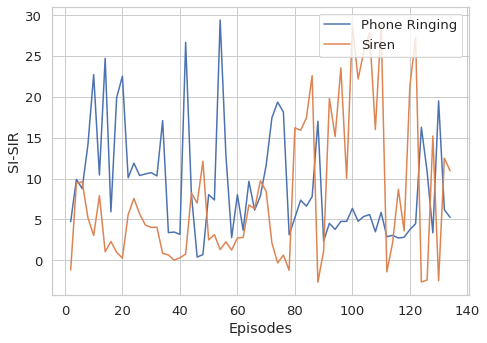

In [650]:
# Plot the SIR 
labels = ['Phone Ringing', 'Siren']
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

plt.figure(figsize=(7, 5))
sns.lineplot(x="Episode", y="SIR", data=df_sir, hue="Sound Class", legend=False)
plt.xlabel('Episodes')
plt.ylabel('SI-SIR')

plt.legend(labels, loc='upper right')
plt.savefig(file_path+'_SIR.png', dpi=dpi)
plt.tight_layout()
plt.show()


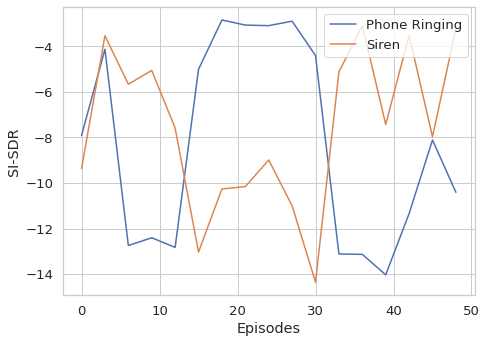

In [638]:
# Plot for SDR 

# Plot the SIR 
labels = ['Phone Ringing', 'Siren']
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

plt.figure(figsize=(7, 5))
sns.lineplot(x="Episode", y="SDR", data=df_sdr, hue="Sound Class", legend=False)
plt.xlabel('Episodes')
plt.ylabel('SI-SDR')

plt.legend(labels, loc='upper right')
plt.savefig(file_path+'_SDR.png', dpi=dpi)
plt.tight_layout()
plt.show()



# sns_plot2 = sns.relplot(x="Episode", y="SDR", data=df_sdr, kind="line", hue="Sound Class", legend=False)
# sns_plot2.set(xlabel='Episodes', ylabel='SI-SDR')

# labels = ['Phone Ringing', 'Siren']
# # for t, l in zip(sns_plot2._legend.texts[1: ], labels): t.set_text(l)
# plt.legend(labels, loc='lower left')

# # sns_plot2.fig.subplots_adjust(top=0.9,right=0.74)
# sns_plot2.savefig(file_path+'_SDR.png', dpi=dpi)

In [639]:
episodes = [x for x, _ in si_sir_source0]

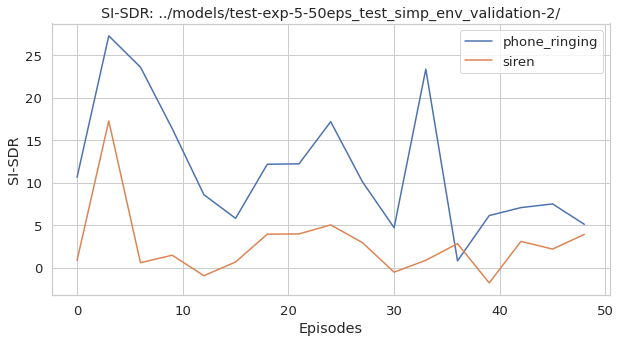

In [640]:
plt.title('SI-SDR: ' + exp_folder)
plt.ylabel('SI-SDR')
plt.xlabel('Episodes')
plt.plot(episodes, [y for _, y in si_sir_source0], label='phone_ringing')
plt.plot(episodes, [y for _, y in si_sir_source1], label='siren')
plt.legend()

#### Best Models for Each Source

In [657]:
best_model_source0 = (None, -np.inf)  # (model episode, si-sir)
best_model_source1 = (None, -np.inf)
for x, y in si_sir_source0:
    if y > best_model_source0[1]:
        best_model_source0 = (x, y)
        
for x, y in si_sir_source1:
    if y > best_model_source1[1]:
        best_model_source1 = (x, y)

In [658]:
best_model_source0

(54, 29.42400470168952)

In [659]:
best_model_source1

(110, 28.842330542439427)

### Best Models (Averaging SI-SIR for both sources)

In [660]:
best_model = (None, -np.inf)  # (model episode, avg(si-sir))
for x, y in avg_sir_list:
    if y > best_model[1]:
        best_model = (x, y)
        
print(best_model)

(100, 17.51622766695923)


In [662]:
print(len(avg_sir_list))
print(avg_sir_list)

67
[(86, 15.205622023032763), (90, 1.7682981808368503), (64, 8.232818433050838), (118, 3.211508651932621), (100, 17.51622766695923), (60, 5.3859891234498605), (120, 12.56636174109626), (134, 8.107838130880692), (92, 12.169412669471452), (70, 10.041400294250383), (18, 10.462858894520366), (66, 6.2332476594812025), (38, 1.7431664288118192), (50, 5.274730762686779), (16, 4.1194734104086645), (98, 7.399786448289345), (88, 7.178816281206826), (122, 15.851097320765996), (82, 11.647081605799853), (54, 15.37342438376593), (76, 9.404613575188856), (124, 6.821117983810417), (96, 14.165235748349662), (46, 3.705792923393264), (40, 1.7452987186848403), (8, 9.691586360010229), (4, 9.682187645964657), (24, 9.735797746803401), (112, 0.7420059196671203), (126, 4.227450673744276), (20, 11.40392940694702), (36, 2.0252641809534655), (42, 13.728308058410468), (52, 5.265498498600648), (48, 6.40870445198997), (78, 0.9633044496683028), (110, 17.35762953768418), (44, 8.163188037890958), (58, 2.018823627443479)